# Modeling

In [1]:
%load_ext jupyternotify
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE as tsne
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

<IPython.core.display.Javascript object>

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
data_df = pd.read_csv('cleaned_data.csv').dropna()
data_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQ

In [4]:
data_df.shape

(1121, 290)

In [5]:
data_df['SalePrice'].describe()

count      1121.000000
mean     185506.152542
std       82999.159004
min       35311.000000
25%      131000.000000
50%      164900.000000
75%      219500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
data_df[data_df['SalePrice']>=164900].shape

(561, 290)

In [7]:
data_df['price_high'] = np.where(data_df['SalePrice']>=164900,1,0)

In [8]:
# Split into train and test sets. Note that the default test_size is 25% (test_size=0.25)
train_df, test_df = train_test_split(data_df)

In [9]:
print(train_df.shape)
print(test_df.shape)

(840, 291)
(281, 291)


In [10]:
X_train = train_df.drop(['SalePrice','price_high'],axis=1)
y_train = train_df['SalePrice']

X_test = test_df.drop(['SalePrice','price_high'],axis=1)
y_test = test_df['SalePrice']

In [11]:
tsne_model = tsne().fit_transform(data_df)

In [12]:
tsne_model

array([[-19.041159  ,  13.040214  ],
       [  2.236302  ,  31.739971  ],
       [-28.273079  ,   7.652243  ],
       ...,
       [-49.503532  ,  18.19438   ],
       [  9.956096  ,  -5.68918   ],
       [ 13.367935  ,  -0.23768248]], dtype=float32)

In [13]:
data_df['x-tsne']=tsne_model[:,0]
data_df['y-tsne']=tsne_model[:,1]

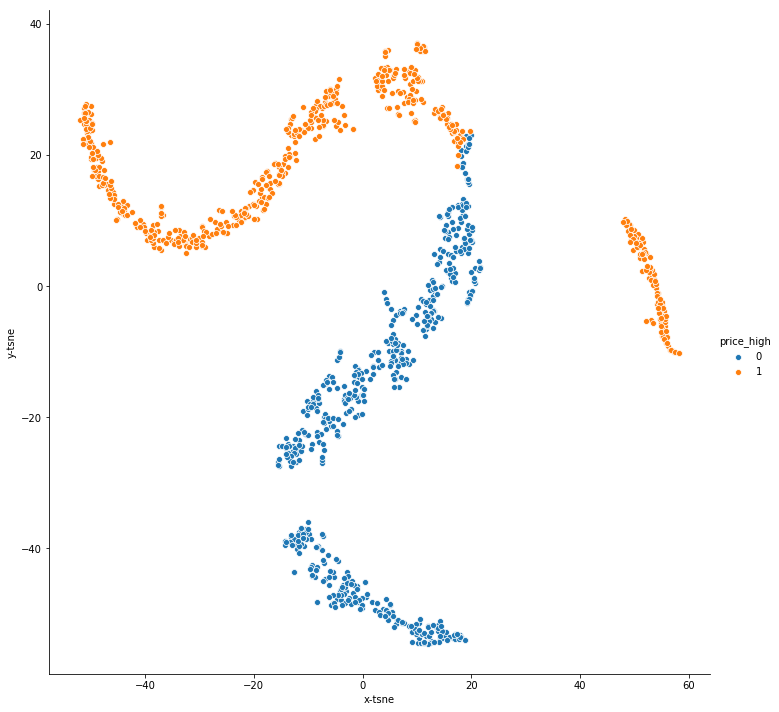

In [14]:
sns.pairplot(x_vars=['x-tsne'], y_vars=['y-tsne'], data=data_df, hue='price_high', height=10)

In [15]:
cluster_labels = AgglomerativeClustering().fit_predict(data_df)

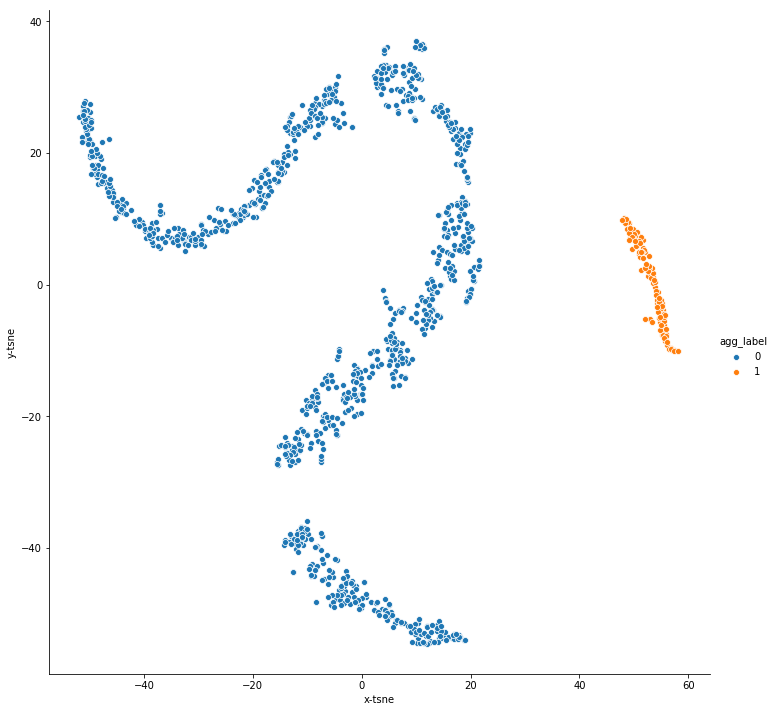

In [16]:
data_df['agg_label'] = cluster_labels
sns.pairplot(x_vars=['x-tsne'], y_vars=['y-tsne'], data=data_df, hue='agg_label', height=10)

In [17]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

# Linear Regression

In [18]:
%%notify -m "Linear Regression Complete!"

linear_model = LinearRegression().fit(X_train, y_train)
# linear_model_predctions = linear_model.predict(test_df.drop('price_high',axis=1))
linear_model_score = linear_model.score(X_test, y_test)
print(linear_model_score)
print(rmse_cv_train(linear_model).mean())
print(rmse_cv_test(linear_model).mean())

0.8692255440165995
107847.01563966984
61313.542718733


<IPython.core.display.Javascript object>

# Lasso Regression

In [29]:
lasso_model = Lasso(max_iter=5e8).fit(X_train, y_train)
lasso_model_score = lasso_model.score(X_test, y_test)
print(lasso_model_score)
print(rmse_cv_train(lasso_model).mean())
print(rmse_cv_test(lasso_model).mean())
%notify -m 'Lasso Regression Complete!'

0.7681455056321804
33763.60218080978
102088.61159739962


# Ridge Regression

In [ ]:
ridge_model = Ridge(max_iter=5e8).fit(X_train, y_train)
ridge_model_score = ridge_model.score(X_test, y_test)
print(ridge_model_score)
print(rmse_cv_train(ridge_model).mean())
print(rmse_cv_test(ridge_model).mean())
%notify -m 'Ridge Regression Complete!'

0.8115957056652653
34891.75652744357
50881.83269616354


# ElasticNet Regression

In [ ]:
elasticnet_model = ElasticNet(max_iter=5e8).fit(X_train, y_train)
elasticnet_model_score = elasticnet_model.score(X_test, y_test)
print(elasticnet_model_score)
print(rmse_cv_train(elasticnet_model).mean())
print(rmse_cv_test(elasticnet_model).mean())
%notify -m 'ElasticNet Regression Complete!'

0.7889841954932011


# RandomForest Regression

In [ ]:
random_forest_model = RandomForestRegressor(n_estimators=5e8).fit(X_train, y_train)
random_forest_model_score = random_forest_model.score(X_test, y_test)
print(random_forest_model_score)
print(rmse_cv_train(random_forest_model).mean())
print(rmse_cv_test(random_forest_model).mean())
%notify -m 'RandomForest Regression Complete!'

# GradientBoosting Regression

In [ ]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators=5e8).fit(X_train, y_train)
gradient_boosting_model_score = gradient_boosting_model.score(X_test, y_test)
print(gradient_boosting_model_score)
print(rmse_cv_train(gradient_boosting_model).mean())
print(rmse_cv_test(gradient_boosting_model).mean())
%notify -m 'GradientBoosting Regression Complete!'